Another alternative for building time series models at scale.  Based on the research from facebook - [Prophet](https://research.fb.com/prophet-forecasting-at-scale/) - allows the user to quickly produce high quality forecasts with the ability to adjust multiple parameters.
Initial code modeled after Digital Ocean's [tutorial](https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-prophet-in-python-3).



In [45]:
!pip install fbprophet

In [0]:
import timeit

In [0]:
%matplotlib inline
import pandas as pd
from fbprophet import Prophet
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [48]:
# OBTAIN

zipcode1 = pd.read_csv('https://raw.githubusercontent.com/jaymahapatra/IST-718-Lab-6/master/zipcode1.csv', sep=',', error_bad_lines=False, encoding = "ISO-8859-1")
zipcode2 = pd.read_csv('https://raw.githubusercontent.com/jaymahapatra/IST-718-Lab-6/master/zipcode2.csv', sep=',', error_bad_lines=False, encoding = "ISO-8859-1")
zipcode=zipcode1.append(zipcode2)
zipcode.head()

#Drop Columns
zipcode = zipcode.drop(columns=['1996-04','1996-05','1996-06','1996-07','1996-08','1996-09','1996-10','1996-11','1996-12'])
zipcode.head()

#Create Little Rock/Hot Springs/Fayetteville/Searcy only Pandas Data frame
ark = (zipcode.loc[zipcode['City'].isin(['Hot Springs','Little Rock','Fayetteville','Searcy'])])
ark1 = (ark.loc[ark['State'].isin(['AR'])])
ark1


hot = (ark1.loc[ark1['City'].isin(['Hot Springs'])])
hot
lit = (ark1.loc[ark1['City'].isin(['Little Rock'])])
lit
fay = (ark1.loc[ark1['City'].isin(['Fayetteville'])])
fay
sea = (ark1.loc[ark1['City'].isin(['Searcy'])])
sea

#spri = (zipcode.loc[zipcode['RegionName'].isin(['92677'])])
#spri


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1997-01,1997-02,1997-03,...,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12
148,96987,92677,Laguna Niguel,CA,Los Angeles-Long Beach-Anaheim,Orange County,149,280700.0,282000.0,283200.0,...,952300,953900,956600,957600,958400,959300,956400,952300,949600,949800


In [49]:
## SOME BASIC TIME DF MANIPULATION

# remove unwanted cols
# df = df.drop(columns = ['RegionID','City','State','Metro','CountyName','SizeRank'])
# convert zip code to col names
# df = df.set_index('ZipCode')
# transpose time series matrices
# df = df.T
# convert indices to date time
# df.index = pd.to_datetime(df.index)
# df.head()

# remove unwanted cols
hot = hot.drop(columns = ['RegionID','RegionName','State','Metro','CountyName','SizeRank'])
# convert zip code to col names
hot = hot.set_index('City')
# transpose time series matrices
hot = hot.T
# convert indices to date time
hot.index = pd.to_datetime(hot.index)
hot.columns = ['HotSprings1','HotSprings2']
hot["Hot Springs3"] = (hot['HotSprings1'] + hot['HotSprings2'])/2
hot=hot.drop(columns=['HotSprings1', 'HotSprings2'])
hot

# remove unwanted cols
lit = lit.drop(columns = ['RegionID','RegionName','State','Metro','CountyName','SizeRank'])
# convert zip code to col names
lit = lit.set_index('City')
# transpose time series matrices
lit = lit.T
# convert indices to date time
lit.index = pd.to_datetime(lit.index)
lit.columns = ['Lit1','Lit2','Lit3','Lit4','Lit5','Lit6','Lit7']
lit['Little Rock'] = (lit['Lit1'] + lit['Lit2'] +lit['Lit3'] + lit['Lit4'] +lit['Lit5'] + lit['Lit6'] + lit['Lit7'])/7
lit=lit.drop(columns=['Lit1','Lit2','Lit3','Lit4','Lit5','Lit6','Lit7'])
lit

# remove unwanted cols
fay = fay.drop(columns = ['RegionID','RegionName','State','Metro','CountyName','SizeRank'])
# convert zip code to col names
fay = fay.set_index('City')
# transpose time series matrices
fay = fay.T
# convert indices to date time
fay.index = pd.to_datetime(fay.index)
fay.columns = ['Fay1','Fay2','Fay3']
fay['Fayetteville'] = (fay['Fay1'] + fay['Fay2'] +fay['Fay3'])/3
fay=fay.drop(columns=['Fay1','Fay2','Fay3'])
fay

# remove unwanted cols
sea = sea.drop(columns = ['RegionID','RegionName','State','Metro','CountyName','SizeRank'])
# convert zip code to col names
sea = sea.set_index('City')
# transpose time series matrices
sea = sea.T
# convert indices to date time
sea.index = pd.to_datetime(sea.index)
sea

sea['Fayetteville'] = fay['Fayetteville']
sea['Little Rock'] = lit['Little Rock']
sea['Hot Springs'] = hot["Hot Springs3"]
ark2 = sea
ark2



City,Searcy,Fayetteville,Little Rock,Hot Springs
1997-01-01,76400.0,92966.666667,126200.000000,73100.0
1997-02-01,76700.0,93466.666667,126800.000000,72950.0
1997-03-01,77000.0,93866.666667,127457.142857,72900.0
1997-04-01,77300.0,94233.333333,128142.857143,73000.0
1997-05-01,77500.0,94366.666667,128757.142857,73200.0
1997-06-01,77700.0,94333.333333,129314.285714,73600.0
1997-07-01,77800.0,94133.333333,129757.142857,74050.0
1997-08-01,77900.0,93833.333333,130071.428571,74600.0
1997-09-01,78000.0,93433.333333,130271.428571,75200.0
1997-10-01,78100.0,93066.666667,130285.714286,75750.0


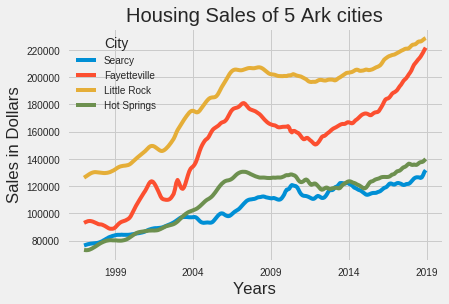

In [50]:
#plot sales of 5 Ark cities
#ark2 = ark2.cumsum()
ark2.plot()
plt.title('Housing Sales of 5 Ark cities')
plt.xlabel('Years')
plt.ylabel('Sales in Dollars')
plt.show()

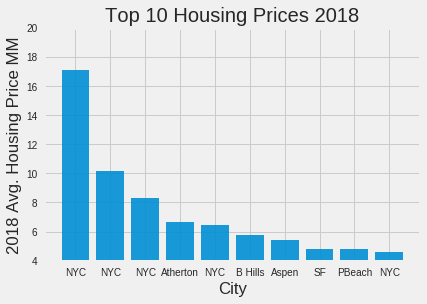

In [126]:
#Current Housing prices by Zip Code
zipcodecurrent = zipcode[['RegionName','City','State','Metro','CountyName','SizeRank','2018-12']].copy()
zipcodecurrent = zipcodecurrent.sort_values(by='2018-12',ascending=[0])
ziptop=zipcodecurrent.head(10)

#Graph Top 10 housing prices 2018
objects = ('NYC', 'NYC', 'NYC', 'Atherton', 'NYC', 'B Hills','Aspen','SF','PBeach','NYC')
y_pos = np.arange(len(objects))
performance = ziptop['2018-12']/1000000
plt.bar(y_pos, performance, align='center', alpha= .9)
plt.xticks(y_pos, objects)
plt.ylabel('2018 Avg. Housing Price MM')
plt.xlabel('City')
plt.title('Top 10 Housing Prices 2018')
plt.ylim(4,20)
plt.show()




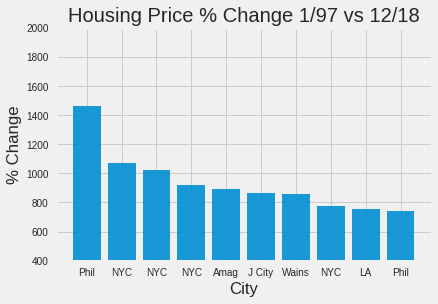

In [129]:
#Percent Change In Housing Prices Long Term
pchange = zipcode[['RegionName','City','State','Metro','CountyName','SizeRank','1997-01','2018-12']].copy()
pchange['change'] = ((pchange['2018-12']-pchange['1997-01'])/pchange['1997-01'])
pchange = pchange.sort_values(by='change',ascending=[0])
pchange.head(10)
ptop=pchange.head(10)
ptop

#Graph Top 10 housing prices percent change long term
objects = ('Phil', 'NYC', 'NYC', 'NYC', 'Amag', 'J City','Wains','NYC','LA','Phil')
y_pos = np.arange(len(objects))
performance = ptop['change']*100
plt.bar(y_pos, performance, align='center', alpha= .9)
plt.xticks(y_pos, objects)
plt.ylabel('% Change')
plt.xlabel('City')
plt.title('Housing Price % Change 1/97 vs 12/18')
plt.ylim(400,2000)
plt.show()


Prophet limits the naming convention of the input columns to be ds (date) and y (the value) - following code renames columns in the Data Frame - and makes data table [dfs] for each department with given format.

In [51]:
# SCRUB
# Rename columns for prophet
#df = df.rename(index=str, columns={"BevSales": "y", "Date": "ds"})
#df.head()

# remove unwanted cols
# df = df.drop(columns = ['RegionID','City','State','Metro','CountyName','SizeRank'])
# convert zip code to col names
# df = df.set_index('ZipCode')
# transpose time series matrices
# df = df.T
# convert indices to date time
# df.index = pd.to_datetime(df.index)
# df.head()

# remove unwanted cols
spri = spri.drop(columns = ['RegionID','City','State','Metro','CountyName','SizeRank'])
# convert zip code to col names
spri = spri.set_index('RegionName')
# transpose time series matrices
spri = spri.T
# convert indices to date time
spri.index = pd.to_datetime(spri.index)
spri.head()

# Rename columns for prophet
spri = spri.rename(index=str, columns={"92677": "y", "RegionName": "ds"})
spri.head()

#Scrub - Thank you Beth!
spri =  spri[spri.columns[0]]

spri = pd.DataFrame(spri).reset_index()
spri.columns=['ds','y']
spri.head()


,ds,y
0,1997-01-01 00:00:00,280700.0
1,1997-02-01 00:00:00,282000.0
2,1997-03-01 00:00:00,283200.0
3,1997-04-01 00:00:00,284700.0
4,1997-05-01 00:00:00,286500.0


,ds,y
0,1997-01-01 00:00:00,280700.0
1,1997-02-01 00:00:00,282000.0
2,1997-03-01 00:00:00,283200.0
3,1997-04-01 00:00:00,284700.0
4,1997-05-01 00:00:00,286500.0


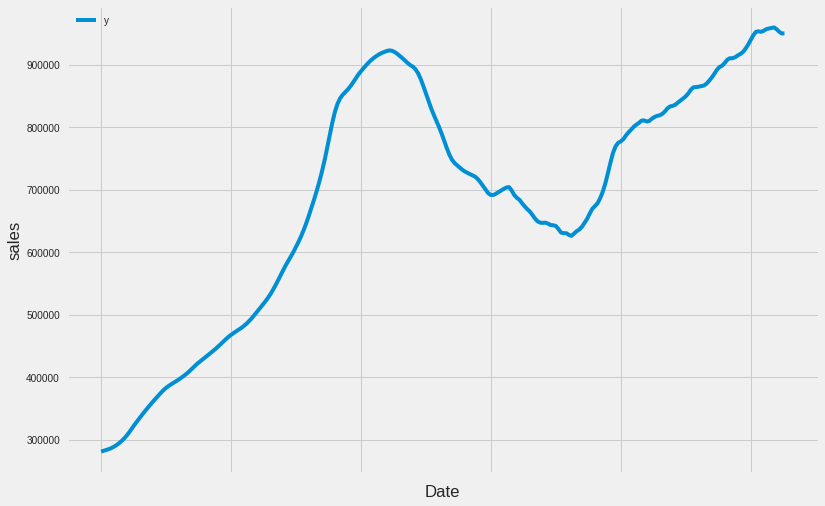

In [52]:
#ax = df.set_index('ds').plot(figsize=(12, 8))
#ax.set_ylabel('Weekly Sales of Beverages')
#ax.set_xlabel('Date')
#plt.show()

ax = spri.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('sales')
ax.set_xlabel('Date')
plt.show()

In [53]:
# MODEL
# Set the uncertainty interval to 95% (the Prophet default is 80%)

bev_model = Prophet(interval_width=0.95)
bev_model.fit(spri)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [72]:
future_dates = bev_model.make_future_dataframe(periods=2, freq='Y')
future_dates.tail()

,ds
261,2018-10-01
262,2018-11-01
263,2018-12-01
264,2018-12-31
265,2019-12-31


In [73]:
# MODEL

forecast = bev_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
261,2018-10-01,9.625529e+05,949715.813079,9.746194e+05
262,2018-11-01,9.653182e+05,953599.399263,9.775767e+05
263,2018-12-01,9.686810e+05,956115.881374,9.805021e+05
264,2018-12-31,9.690070e+05,956237.954086,9.812831e+05
265,2019-12-31,1.004402e+06,938490.561587,1.067847e+06


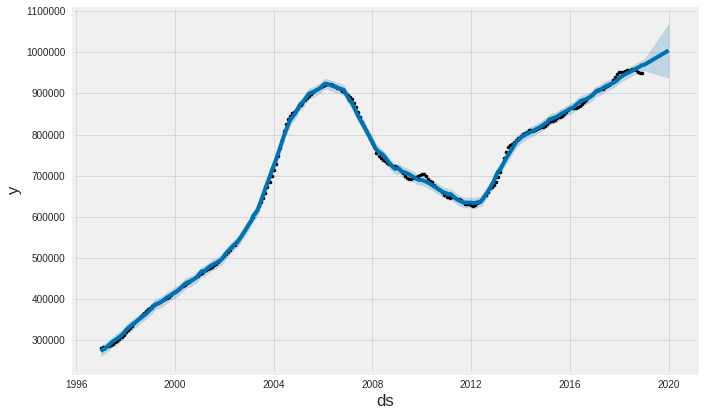

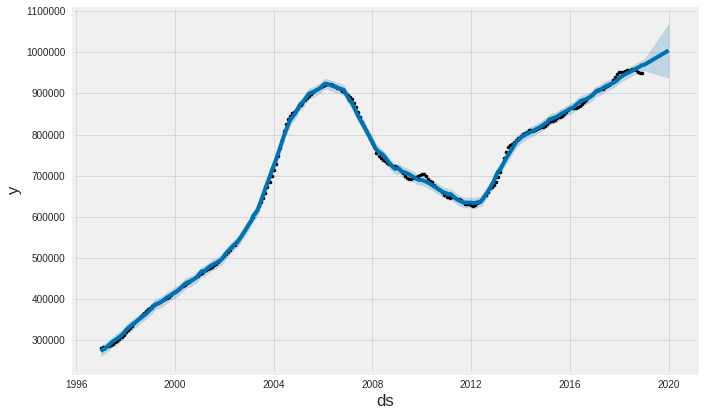

In [74]:
# MODEL

bev_model.plot(forecast, uncertainty=True)

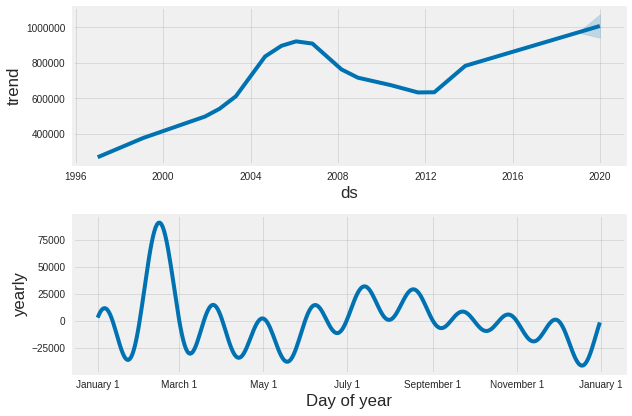

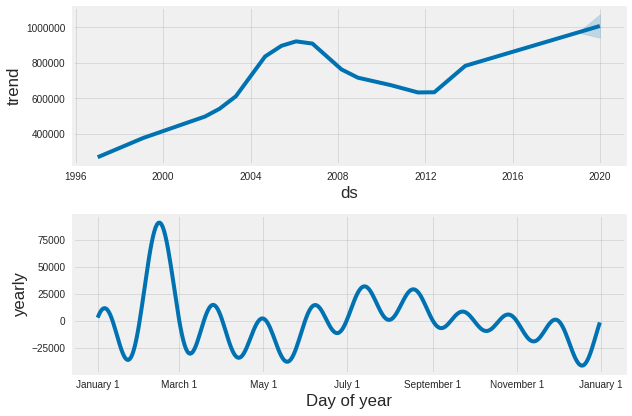

In [75]:
# INTERPRET

bev_model.plot_components(forecast)
